# 04. PyTorch Custom Datasets Exercises Template



In [52]:
# Check for GPU
!nvidia-smi

Sat Jun 28 01:50:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             31W /   70W |    2468MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from typing import Tuple, Dict, List

import requests
import zipfile
from pathlib import Path
import os
from urllib import request

import random
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary

from tqdm.auto import tqdm

from timeit import default_timer as timer

import torchvision
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1.0 Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

## 2.0 Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [54]:
# 1. Get data
data_path = Path("custom_data/")
food_types = "pizza_steak_sushi"
img_data_path = data_path / food_types
f_type_z, f_type_i = ".zip", ".jpg"
url_to_download =  "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/"+ food_types + f_type_z
f_path = img_data_path / f_type_z

if img_data_path.is_dir():
    print(f"{img_data_path} directory already exists, skipping downloading.")
else:
    print(f"Did not find {img_data_path} directory, creating one...")
    img_data_path.mkdir(parents=True, exist_ok=True)
    print(f"Downloading images of: {food_types}")
    with open(f_path, "wb") as f:
        request = requests.get(url_to_download)
        f.write(request.content)
    with zipfile.ZipFile(f_path, "r") as zip_ref:
        print("Unzipping images of: " + food_types)
        zip_ref.extractall(img_data_path)

custom_data/pizza_steak_sushi directory already exists, skipping downloading.


In [55]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [56]:
walk_through_dir(img_data_path)

There are 2 directories and 1 images in 'custom_data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'custom_data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'custom_data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'custom_data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'custom_data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'custom_data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'custom_data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'custom_data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'custom_data/pizza_steak_sushi/test/pizza'.


In [57]:
# Setup train and testing paths
training_dir = img_data_path / "train"
testing_dir = img_data_path / "test"

training_dir, testing_dir

(PosixPath('custom_data/pizza_steak_sushi/train'),
 PosixPath('custom_data/pizza_steak_sushi/test'))

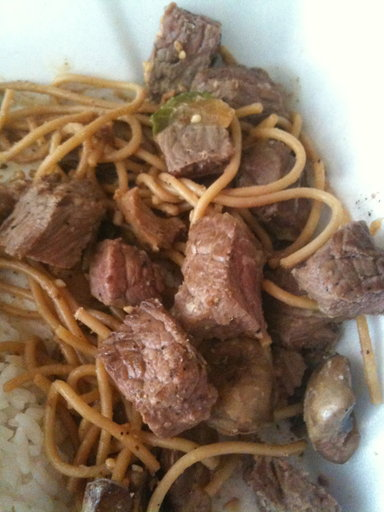

In [58]:
# Visualize an image
img_data_path_list = list(img_data_path.glob("*/*/*" + f_type_i))
random_img_path = random.choice(img_data_path_list)
img_lbl = random_img_path.parent.stem
random_img = Image.open(random_img_path)
random_img

Text(0.5, 1.0, 'Image shape: (512, 384, 3) | Label: steak')

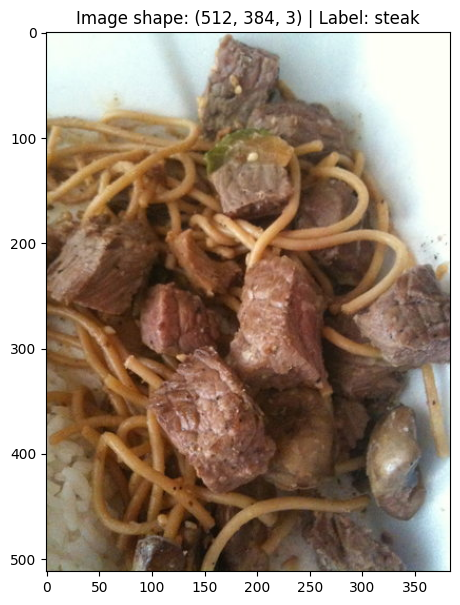

In [59]:
# Do the image visualization with matplotlib
img_as_array = np.asarray(random_img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image shape: {img_as_array.shape} | Label: {img_lbl}")

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [60]:
# 3.1 Transforming data with torchvision.transforms
img_to_tensor_fn = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [61]:
# Write transform for turning images into tensors
img_to_tensor_fn(random_img)

tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9725, 0.9725, 0.9686],
         [0.9961, 0.9961, 0.9961,  ..., 0.9686, 0.9686, 0.9647],
         [0.9961, 0.9961, 0.9961,  ..., 0.9647, 0.9608, 0.9529],
         ...,
         [0.9373, 0.8471, 0.7294,  ..., 0.5569, 0.5569, 0.5529],
         [0.9412, 0.8275, 0.6941,  ..., 0.5686, 0.5843, 0.5882],
         [0.9255, 0.8118, 0.6784,  ..., 0.5686, 0.5725, 0.5961]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9961],
         ...,
         [0.9922, 0.9529, 0.8510,  ..., 0.5294, 0.5216, 0.5255],
         [0.9922, 0.9412, 0.8196,  ..., 0.5294, 0.5529, 0.5647],
         [0.9882, 0.9255, 0.8000,  ..., 0.5569, 0.5647, 0.5804]],

        [[0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9725],
         [0.9686, 0.9686, 0.9686,  ..., 0.9686, 0.9725, 0.9725],
         [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9765, 0.

In [62]:
# Write a function to plot transformed images
def show_transformed_images(image_path: list, transform, n=3, seed=42):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_path, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original size:\n {f.size}")
      ax[0].axis(False)

    # Transform and plot image
    transformed_image = transform(f).permute(1, 2, 0)
    ax[1].imshow(transformed_image)
    ax[1].set_title(f"Transformed size:\n {transformed_image.shape}")
    ax[1].axis(False)
    fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

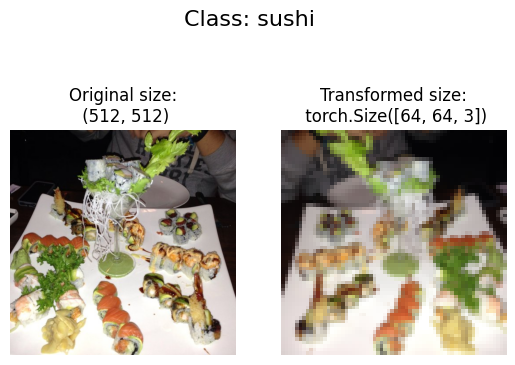

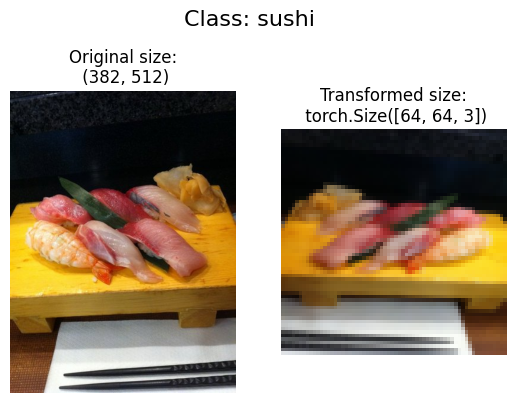

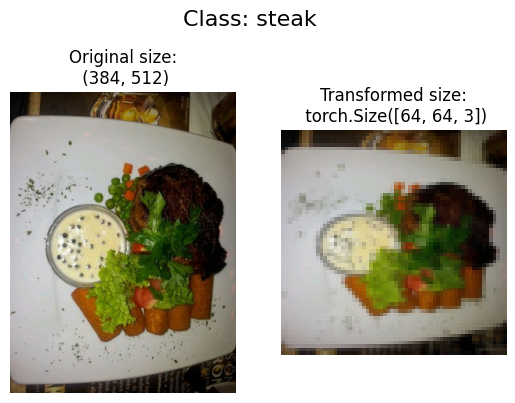

In [63]:
show_transformed_images(img_data_path_list, img_to_tensor_fn, n=3)

### 2.1 Load image data using `ImageFolder`

In [64]:
# Use ImageFolder to create dataset(s)
training_datasets = datasets.ImageFolder(
    root=training_dir,
    transform=img_to_tensor_fn, target_transform=None)

testing_datasets = datasets.ImageFolder(
    root=testing_dir, transform=img_to_tensor_fn)

In [65]:
print(f"training_data:\n{training_datasets}\n")
print(f"testing_data:\n{testing_datasets}")

training_data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: custom_data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

testing_data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: custom_data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [66]:
# Get class names as a list
class_names = training_datasets.classes
class_names

['pizza', 'steak', 'sushi']

In [67]:
# Can also get class names as a dict
class_dict = training_datasets.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [68]:
# Check the lengths of each dataset
len(training_datasets), len(testing_datasets)

(225, 75)

In [69]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=training_datasets,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=testing_datasets,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ea51f757350>,
 <torch.utils.data.dataloader.DataLoader at 0x7ea537d3c750>)

In [70]:
# How many batches of images are in our data loaders?
train_dataloader.batch_size

32

## 3.0 Recreate `model_0` we built in section 7 of notebook 04.

In [71]:
class Model_0_TinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
               super().__init__()
               self.block_1 = nn.Sequential(
               nn.Conv2d(in_channels=input_shape,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
               nn.ReLU(),
               nn.Conv2d(in_channels=hidden_units,
                            out_channels=hidden_units,
                            kernel_size=3,
                            stride=1,
                            padding=1),
               nn.ReLU(),
               nn.MaxPool2d(kernel_size=2,
                              stride=2))
               self.block_2 = nn.Sequential(
                  nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
               nn.ReLU(),
               nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.MaxPool2d(2))
               self.classifier = nn.Sequential(
               nn.Flatten(),
               nn.Linear(in_features=hidden_units*16*16,
                            out_features=output_shape))
  def forward(self, x: torch.Tensor):
    return self.classifier(self.block_2(self.block_1(x)))

In [72]:
model_0 = Model_0_TinyVGG(input_shape=3,
                          hidden_units=10,
                          output_shape=len(class_names)).to(device)
model_0

Model_0_TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4.0 Create training and testing functions for `model_0`.

In [73]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [74]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      # 1. Forward pass
      test_pred_logits = model(X)
      # 2. Calculate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      # 3. Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [75]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5.0 Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [76]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

model_0 = Model_0_TinyVGG(input_shape=3,
                          hidden_units=10,
                          output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

start_time = timer()
model_0_results_5 = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCHS)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds with {EPOCHS} epochs")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2695 | test_loss: 1.1380 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0828 | train_acc: 0.4258 | test_loss: 1.1681 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1203 | train_acc: 0.2930 | test_loss: 1.1727 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0949 | train_acc: 0.4141 | test_loss: 1.1416 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0946 | train_acc: 0.2930 | test_loss: 1.1404 | test_acc: 0.1979
Total training time: 4.654 seconds with 5 epochs


In [77]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
start_time = timer()
model_0_results_20 = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds with {EPOCHS} epochs")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0921 | train_acc: 0.4727 | test_loss: 1.0966 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0651 | train_acc: 0.4883 | test_loss: 1.1013 | test_acc: 0.3021
Epoch: 3 | train_loss: 1.0322 | train_acc: 0.4492 | test_loss: 1.1276 | test_acc: 0.2917
Epoch: 4 | train_loss: 1.0361 | train_acc: 0.3984 | test_loss: 1.1358 | test_acc: 0.2708
Epoch: 5 | train_loss: 0.9770 | train_acc: 0.5234 | test_loss: 1.1004 | test_acc: 0.3011
Epoch: 6 | train_loss: 1.0247 | train_acc: 0.4531 | test_loss: 1.0636 | test_acc: 0.3419
Epoch: 7 | train_loss: 0.8261 | train_acc: 0.6328 | test_loss: 1.0664 | test_acc: 0.4744
Epoch: 8 | train_loss: 0.8383 | train_acc: 0.6758 | test_loss: 1.0631 | test_acc: 0.3314
Epoch: 9 | train_loss: 0.9388 | train_acc: 0.4805 | test_loss: 1.0700 | test_acc: 0.3826
Epoch: 10 | train_loss: 0.8552 | train_acc: 0.5352 | test_loss: 1.0116 | test_acc: 0.5350
Epoch: 11 | train_loss: 0.8366 | train_acc: 0.6484 | test_loss: 1.0230 | test_acc: 0.4337
Epoch: 12 | train_l

In [78]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
start_time = timer()
model_0_results_50 = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=50)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds with {EPOCHS} epochs")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7068 | train_acc: 0.7539 | test_loss: 1.0847 | test_acc: 0.3532
Epoch: 2 | train_loss: 0.7570 | train_acc: 0.5742 | test_loss: 1.0120 | test_acc: 0.4545
Epoch: 3 | train_loss: 0.6867 | train_acc: 0.7148 | test_loss: 0.9383 | test_acc: 0.5360
Epoch: 4 | train_loss: 0.6978 | train_acc: 0.7461 | test_loss: 1.0055 | test_acc: 0.4545
Epoch: 5 | train_loss: 0.6351 | train_acc: 0.7500 | test_loss: 1.0336 | test_acc: 0.4953
Epoch: 6 | train_loss: 0.8576 | train_acc: 0.6094 | test_loss: 0.9427 | test_acc: 0.5246
Epoch: 7 | train_loss: 0.6188 | train_acc: 0.7305 | test_loss: 1.0042 | test_acc: 0.4962
Epoch: 8 | train_loss: 0.6530 | train_acc: 0.7578 | test_loss: 1.1163 | test_acc: 0.3930
Epoch: 9 | train_loss: 0.8193 | train_acc: 0.5742 | test_loss: 1.0566 | test_acc: 0.4432
Epoch: 10 | train_loss: 0.6790 | train_acc: 0.6953 | test_loss: 0.9687 | test_acc: 0.5748
Epoch: 11 | train_loss: 0.6285 | train_acc: 0.7344 | test_loss: 1.1163 | test_acc: 0.3636
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6.0 Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [79]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = Model_0_TinyVGG(input_shape=3,
                          hidden_units=20,
                          output_shape=len(class_names)).to(device)
start_time = timer()
model_1_results_20 = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3363 | train_acc: 0.8555 | test_loss: 1.4863 | test_acc: 0.4972
Epoch: 2 | train_loss: 0.3167 | train_acc: 0.8906 | test_loss: 1.4276 | test_acc: 0.4763
Epoch: 3 | train_loss: 0.4015 | train_acc: 0.7617 | test_loss: 1.4579 | test_acc: 0.5170
Epoch: 4 | train_loss: 0.7575 | train_acc: 0.7422 | test_loss: 2.0510 | test_acc: 0.4044
Epoch: 5 | train_loss: 0.6448 | train_acc: 0.7266 | test_loss: 1.1845 | test_acc: 0.5360
Epoch: 6 | train_loss: 0.5865 | train_acc: 0.7578 | test_loss: 1.9767 | test_acc: 0.3532
Epoch: 7 | train_loss: 0.4689 | train_acc: 0.8242 | test_loss: 1.4269 | test_acc: 0.4564
Epoch: 8 | train_loss: 0.3432 | train_acc: 0.8867 | test_loss: 1.3458 | test_acc: 0.4640
Epoch: 9 | train_loss: 0.3453 | train_acc: 0.8945 | test_loss: 1.4255 | test_acc: 0.4858
Epoch: 10 | train_loss: 0.4966 | train_acc: 0.7617 | test_loss: 1.7319 | test_acc: 0.4148
Epoch: 11 | train_loss: 0.8671 | train_acc: 0.7344 | test_loss: 1.4465 | test_acc: 0.4650
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7.0 Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [80]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [81]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.


Excellent, we now have double the training and testing images...

In [82]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [83]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(root=train_data_20_percent_path,
                                    transform=simple_transform,
                                    target_transform=None)

test_data_20_percent = ImageFolder(root=test_data_20_percent_path,
                                   transform=simple_transform,
                                   target_transform=None)

# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         shuffle=True)
test_dataloader_20_percent = DataLoader(dataset=test_data_20_percent,
                                        batch_size=BATCH_SIZE,
                                        num_workers=NUM_WORKERS,
                                        shuffle=False)
train_dataloader_20_percent, test_dataloader_20_percent


(<torch.utils.data.dataloader.DataLoader at 0x7ea51fbc9710>,
 <torch.utils.data.dataloader.DataLoader at 0x7ea51f67c750>)

In [84]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_2 = Model_0_TinyVGG(input_shape=3,
                          hidden_units=20,
                          output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001)

start_time = timer()
model_2_results = train(model=model_2,
                train_dataloader=train_dataloader_20_percent,
                test_dataloader=test_dataloader_20_percent,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds with {EPOCHS} epochs")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.3312 | test_loss: 1.1003 | test_acc: 0.2875
Epoch: 2 | train_loss: 1.0837 | train_acc: 0.3583 | test_loss: 1.0734 | test_acc: 0.3517
Epoch: 3 | train_loss: 1.0319 | train_acc: 0.4333 | test_loss: 0.9631 | test_acc: 0.4892
Epoch: 4 | train_loss: 0.9209 | train_acc: 0.5521 | test_loss: 0.9115 | test_acc: 0.5847
Epoch: 5 | train_loss: 0.8637 | train_acc: 0.6750 | test_loss: 0.9066 | test_acc: 0.6028
Epoch: 6 | train_loss: 0.8841 | train_acc: 0.5771 | test_loss: 0.9271 | test_acc: 0.5705
Epoch: 7 | train_loss: 0.8724 | train_acc: 0.6083 | test_loss: 0.8890 | test_acc: 0.5256
Epoch: 8 | train_loss: 0.7671 | train_acc: 0.6792 | test_loss: 0.9079 | test_acc: 0.5886
Epoch: 9 | train_loss: 0.7861 | train_acc: 0.6813 | test_loss: 0.8885 | test_acc: 0.5210
Epoch: 10 | train_loss: 0.7816 | train_acc: 0.6792 | test_loss: 0.8550 | test_acc: 0.6347
Epoch: 11 | train_loss: 0.6954 | train_acc: 0.7250 | test_loss: 0.9409 | test_acc: 0.5597
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [85]:
custom_image_url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg"
custom_image_path = Path("data/pizza_dad.jpeg")
if not custom_image_path.is_file():
  with open (custom_image_path, "wb") as f:
    print(f"Downloading image to: {custom_image_path}")
    f.write(requests.get(custom_image_url).content)
else:
  print(f"{custom_image_path} already exists")

data/pizza_dad.jpeg already exists


In [86]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

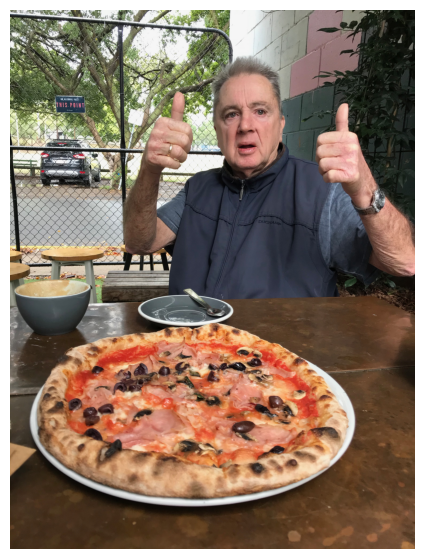

In [87]:
plt.figure(figsize=(10, 7))
plt.imshow(custom_image.permute(1, 2, 0))
plt.axis(False)

In [88]:
# custom_image_transform = transforms.Compose([
#   transforms.Resize((64, 64))])
# custom_image_transformed = custom_image_transform(custom_image)
# custom_image_transformed.shape

In [89]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device: torch.device = device):

  target_img = torchvision.io.read_image(str(image_path)).type(torch.float32)

  if transform:
    # Apply transform to the tensor image and normalize
    target_img = transform(target_img)
    target_img = target_img / 255.0

  # Add a batch dimension
  target_img = target_img.unsqueeze(dim=0).to(device)

  model.to(device)
  model.eval()
  with torch.inference_mode():
    target_img_pred = model(target_img)
  target_img_pred_probs = torch.softmax(target_img_pred, dim=1)
  target_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)
  plt.imshow(target_img.squeeze().permute(1, 2, 0).cpu()) # Squeeze the batch dimension and move to CPU for plotting
  if class_names:
    title = f"Pred: {class_names[target_img_pred_label.cpu()]} | Prob: {target_img_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_img_pred_label} | Prob: {target_img_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

# Create a new transform without ToTensor for the tensor image
custom_image_transform_no_totensor = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
])

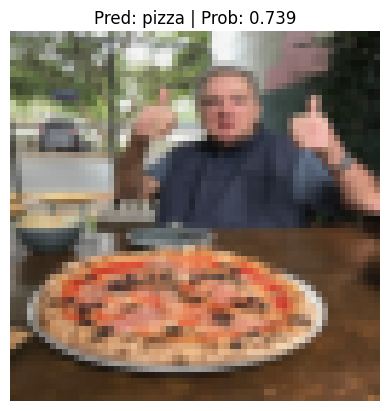

In [90]:
pred_and_plot_image(model=model_2,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform_no_totensor, # Use the modified transform
                    device=device)

In [91]:
# import shutil
# import os

# folder_path = 'custom_data'

# # Check if the folder exists before attempting to delete it
# if os.path.exists(folder_path):
#     shutil.rmtree(folder_path)
#     print(f"Folder '{folder_path}' deleted successfully.")
# else:
#     print(f"Folder '{folder_path}' does not exist.")